# Phase 3: Data Preprocessing & Baseline Models

**Objectives:**
1. Prepare data for machine learning (scaling, encoding, splitting)
2. Create train-test splits with stratification
3. Train baseline models to validate preprocessing

---

## 1. Setup & Data Loading

In [36]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
from datetime import datetime

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    make_scorer
)

# Models for baseline testing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully")
print(f"Random seed set to: {RANDOM_STATE}")

Libraries imported successfully
Random seed set to: 42


In [37]:
# Create output directories for this phase
output_dirs = [
    '../results/preprocessing',
    '../results/preprocessing/plots',
    '../results/preprocessing/metrics',
    '../data/processed',
    '../models'
]

for directory in output_dirs:
    os.makedirs(directory, exist_ok=True)
    
print("Output directories created:")
for d in output_dirs:
    print(f"  - {d}")

Output directories created:
  - ../results/preprocessing
  - ../results/preprocessing/plots
  - ../results/preprocessing/metrics
  - ../data/processed
  - ../models


In [38]:
# Load the dataset
data_path = '../data/raw/classData.csv'
data = pd.read_csv(data_path)

print("Dataset loaded successfully!")
print(f"Shape: {data.shape}")
print(f"\nFirst few rows:")
data.head()

Dataset loaded successfully!
Shape: (7861, 10)

First few rows:


,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


---
## 2. Create Fault Type Labels

Converting the binary fault indicators (G, C, B, A) into a single categorical label.

In [39]:
# Convert fault indicator columns to a single label
data['Fault_Type'] = data[['G', 'C', 'B', 'A']].astype(str).agg(''.join, axis=1)

# Define fault type mappings
fault_types = {
    '0000': 'No Fault',
    '1000': 'Single Line to Ground A',
    '0100': 'Single Line to Ground B',
    '0010': 'Single Line to Ground C',
    '0011': 'Line-to-Line BC',
    '0101': 'Line-to-Line AC',
    '1001': 'Line-to-Line AB',
    '1010': 'Line-to-Line with Ground AB',
    '0110': 'Line-to-Line with Ground BC',
    '0111': 'Three-Phase',
    '1111': 'Three-Phase with Ground',
    '1011': 'Line A Line B to Ground Fault'
}

# Map fault codes to names
data['Fault_Type'] = data['Fault_Type'].map(fault_types)

# Display fault type distribution
print("Fault Type Distribution:")
print("-" * 50)
fault_counts = data['Fault_Type'].value_counts()
print(fault_counts)

print(f"\nTotal samples: {len(data)}")
print(f"Number of fault types: {data['Fault_Type'].nunique()}")

Fault Type Distribution:
--------------------------------------------------
Fault_Type
No Fault                         2365
Line A Line B to Ground Fault    1134
Three-Phase with Ground          1133
Line-to-Line AB                  1129
Three-Phase                      1096
Line-to-Line with Ground BC      1004
Name: count, dtype: int64

Total samples: 7861
Number of fault types: 6


Saved: results/preprocessing/plots/01_fault_type_distribution.png


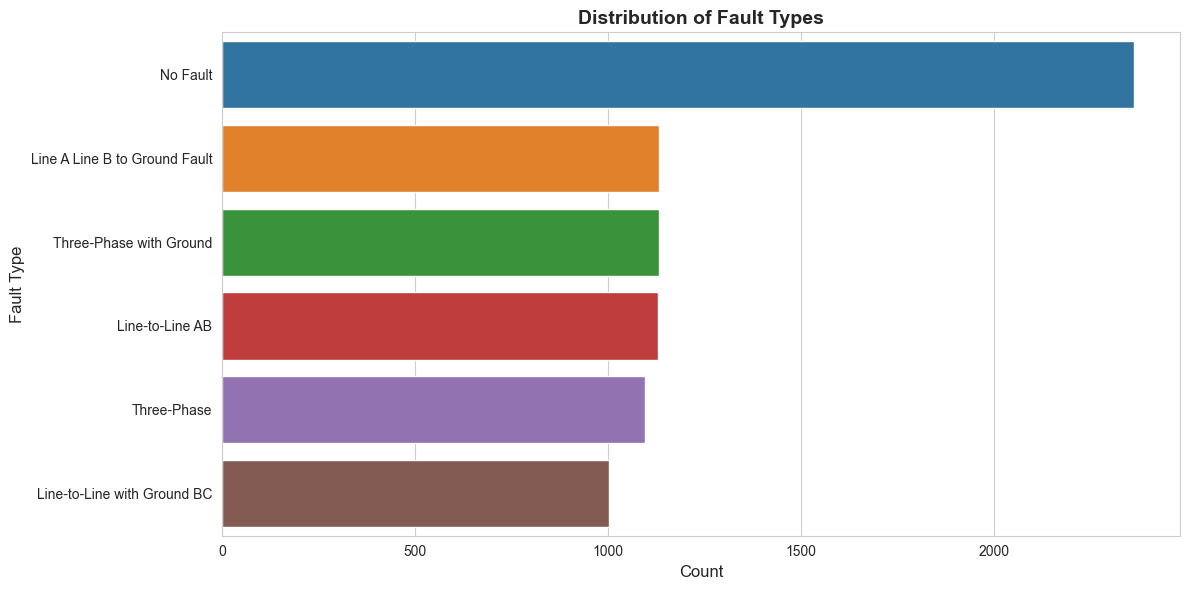


Class Imbalance Analysis:
  Maximum samples: 2365 (No Fault)
  Minimum samples: 1004 (Line-to-Line with Ground BC)
  Imbalance ratio: 2.36:1
Class imbalance is manageable


In [41]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='Fault_Type', order=fault_counts.index, palette='tab10')
plt.title('Distribution of Fault Types', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Fault Type', fontsize=12)
plt.tight_layout()

# Save plot
plt.savefig('../results/preprocessing/plots/01_fault_type_distribution.png', dpi=300, bbox_inches='tight')
print("Saved: results/preprocessing/plots/01_fault_type_distribution.png")
plt.show()

# Calculate class imbalance ratio
max_count = fault_counts.max()
min_count = fault_counts.min()
imbalance_ratio = max_count / min_count

print(f"\nClass Imbalance Analysis:")
print(f"  Maximum samples: {max_count} ({fault_counts.index[0]})")
print(f"  Minimum samples: {min_count} ({fault_counts.index[-1]})")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("Significant class imbalance detected - may need SMOTE later")
else:
    print("Class imbalance is manageable")

---
## 3. Feature Preparation

Selecting the features for model training (current and voltage measurements).

In [42]:
# Define feature columns
feature_columns = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

print("Selected Features:")
print("-" * 50)
for i, feature in enumerate(feature_columns, 1):
    print(f"{i}. {feature}")

# Extract features and target
X = data[feature_columns].copy()
y = data['Fault_Type'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Display feature statistics
print("\nFeature Statistics:")
print("-" * 50)
print(X.describe())

Selected Features:
--------------------------------------------------
1. Ia
2. Ib
3. Ic
4. Va
5. Vb
6. Vc

Feature matrix shape: (7861, 6)
Target vector shape: (7861,)

Feature Statistics:
--------------------------------------------------
                Ia           Ib           Ic           Va           Vb  \
count  7861.000000  7861.000000  7861.000000  7861.000000  7861.000000   
mean     13.721194   -44.845268    34.392394    -0.007667     0.001152   
std     464.741671   439.269195   371.107412     0.289150     0.313437   
min    -883.542316  -900.526951  -883.357762    -0.620748    -0.608016   
25%    -119.802518  -271.845947   -61.034219    -0.130287    -0.159507   
50%       2.042805     5.513317    -4.326711    -0.005290     0.001620   
75%     227.246377    91.194282    49.115141     0.111627     0.153507   
max     885.738571   889.868884   901.274261     0.595342     0.627875   

                Vc  
count  7861.000000  
mean      0.006515  
std       0.307897  
min      

---
## 4. Feature Scaling

Using MinMaxScaler to normalize features to [0, 1] range.

Saved: results/preprocessing/plots/02_features_before_scaling.png


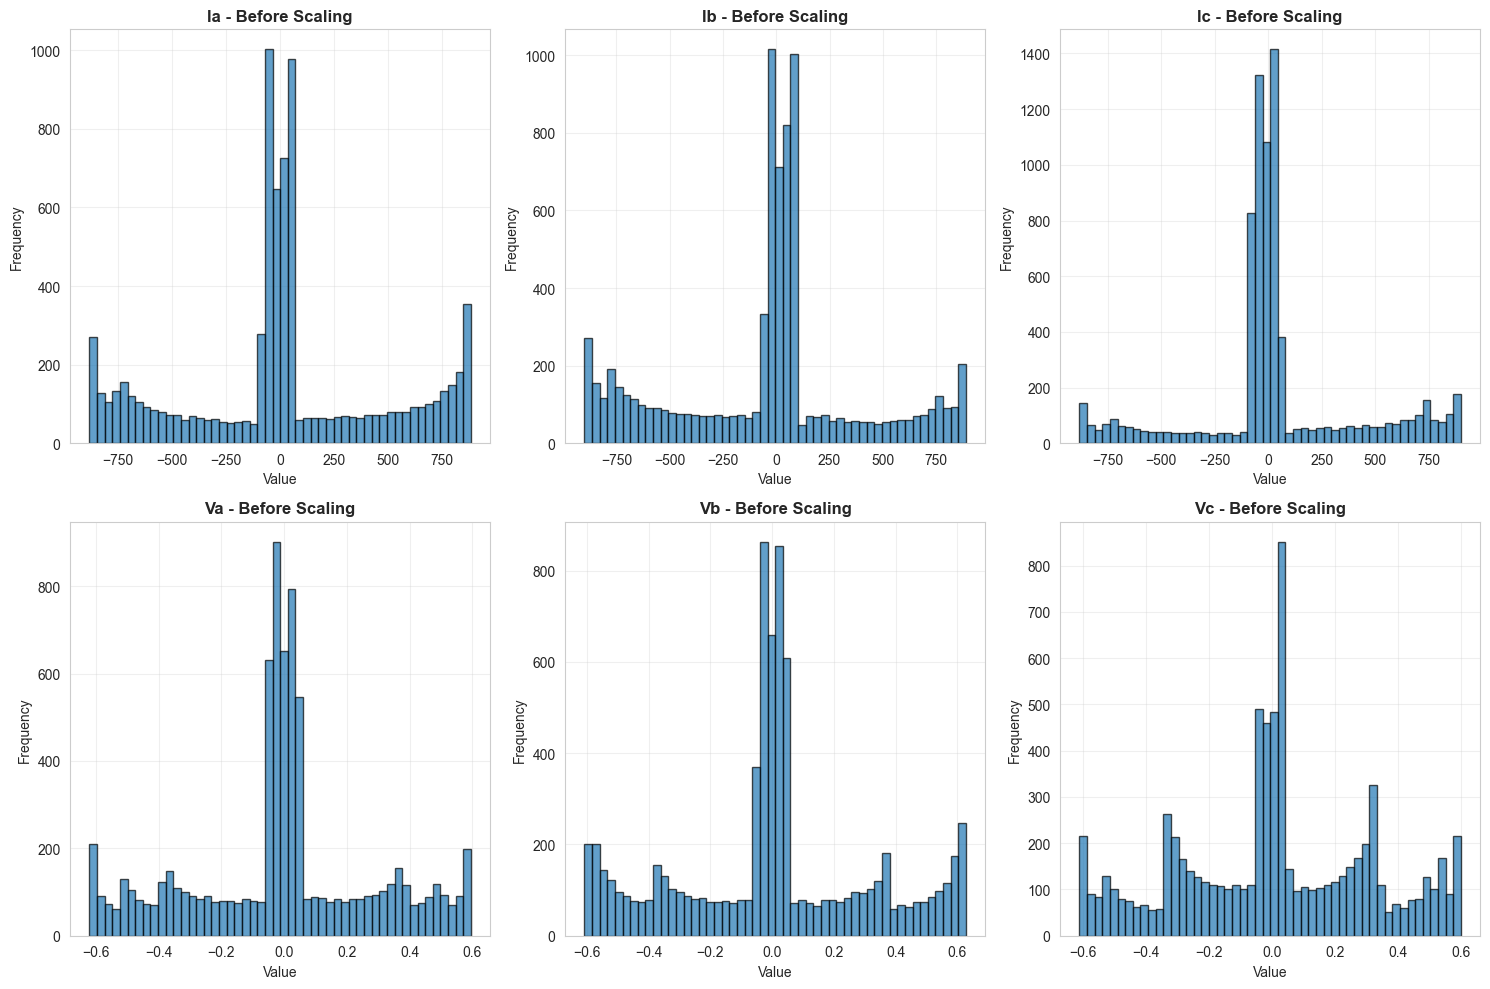

In [44]:
# Visualize feature distributions before scaling
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(feature_columns):
    axes[idx].hist(X[feature], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature} - Before Scaling', fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/preprocessing/plots/02_features_before_scaling.png', dpi=300, bbox_inches='tight')
print("Saved: results/preprocessing/plots/02_features_before_scaling.png")
plt.show()

In [ ]:
# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Features scaled using MinMaxScaler")
print(f"\nScaled feature range: [{X_scaled.min():.4f}, {X_scaled.max():.4f}]")
print(f"\nOriginal feature ranges:")
for feature in feature_columns:
    print(f"  {feature}: [{X[feature].min():.2f}, {X[feature].max():.2f}]")

Features scaled using MinMaxScaler

Scaled feature range: [0.0000, 1.0000]

Original feature ranges:
  Ia: [-883.54, 885.74]
  Ib: [-900.53, 889.87]
  Ic: [-883.36, 901.27]
  Va: [-0.62, 0.60]
  Vb: [-0.61, 0.63]
  Vc: [-0.61, 0.60]


Saved: results/preprocessing/plots/03_features_after_scaling.png


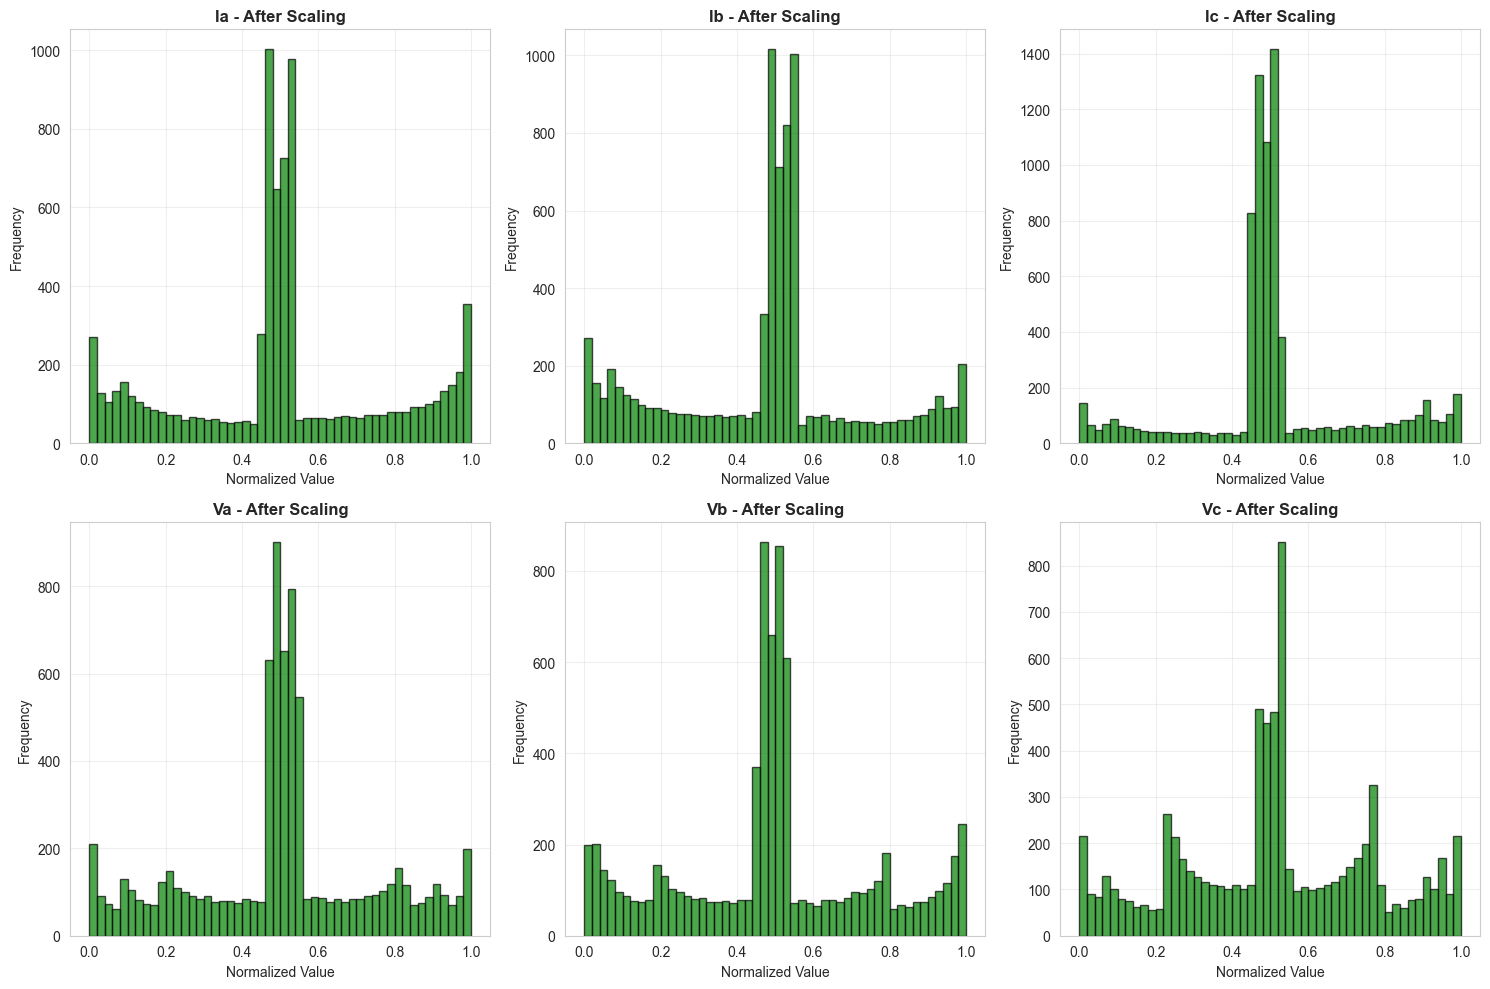

In [45]:
# Visualize features after scaling
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(feature_columns):
    axes[idx].hist(X_scaled_df[feature], bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[idx].set_title(f'{feature} - After Scaling', fontweight='bold')
    axes[idx].set_xlabel('Normalized Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/preprocessing/plots/03_features_after_scaling.png', dpi=300, bbox_inches='tight')
print("Saved: results/preprocessing/plots/03_features_after_scaling.png")
plt.show()

---
## 5. Label Encoding

Converting fault type names to numerical labels for model training.

In [46]:
# Initialize and fit label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Target labels encoded")
print(f"\nLabel Mapping:")
print("-" * 50)
for idx, fault_name in enumerate(label_encoder.classes_):
    count = (y_encoded == idx).sum()
    print(f"{idx}: {fault_name} (n={count})")

print(f"\nEncoded labels shape: {y_encoded.shape}")
print(f"Unique labels: {np.unique(y_encoded)}")

Target labels encoded

Label Mapping:
--------------------------------------------------
0: Line A Line B to Ground Fault (n=1134)
1: Line-to-Line AB (n=1129)
2: Line-to-Line with Ground BC (n=1004)
3: No Fault (n=2365)
4: Three-Phase (n=1096)
5: Three-Phase with Ground (n=1133)

Encoded labels shape: (7861,)
Unique labels: [0 1 2 3 4 5]


---
## 6. Train-Test Split

80-20 split with stratification to maintain class distribution.

In [47]:
# Perform stratified train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y_encoded, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y_encoded
)

print("Data split completed (80-20)")
print("\nDataset Shapes:")
print("-" * 50)
print(f"Training set:   X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set:       X_test {X_test.shape}, y_test {y_test.shape}")

# Verify stratification
print("\nClass Distribution Verification:")
print("-" * 50)
print("\nOriginal distribution:")
original_dist = pd.Series(y_encoded).value_counts(normalize=True).sort_index()
print(original_dist)

print("\nTraining set distribution:")
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
print(train_dist)

print("\nTest set distribution:")
test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index()
print(test_dist)

print("\nStratification successful - distributions match")

Data split completed (80-20)

Dataset Shapes:
--------------------------------------------------
Training set:   X_train (6288, 6), y_train (6288,)
Test set:       X_test (1573, 6), y_test (1573,)

Class Distribution Verification:
--------------------------------------------------

Original distribution:
0    0.144256
1    0.143620
2    0.127719
3    0.300852
4    0.139422
5    0.144129
Name: proportion, dtype: float64

Training set distribution:
0    0.144243
1    0.143607
2    0.127704
3    0.300891
4    0.139472
5    0.144084
Name: proportion, dtype: float64

Test set distribution:
0    0.144310
1    0.143675
2    0.127781
3    0.300699
4    0.139224
5    0.144310
Name: proportion, dtype: float64

Stratification successful - distributions match


Saved: results/preprocessing/plots/04_train_test_split_distribution.png


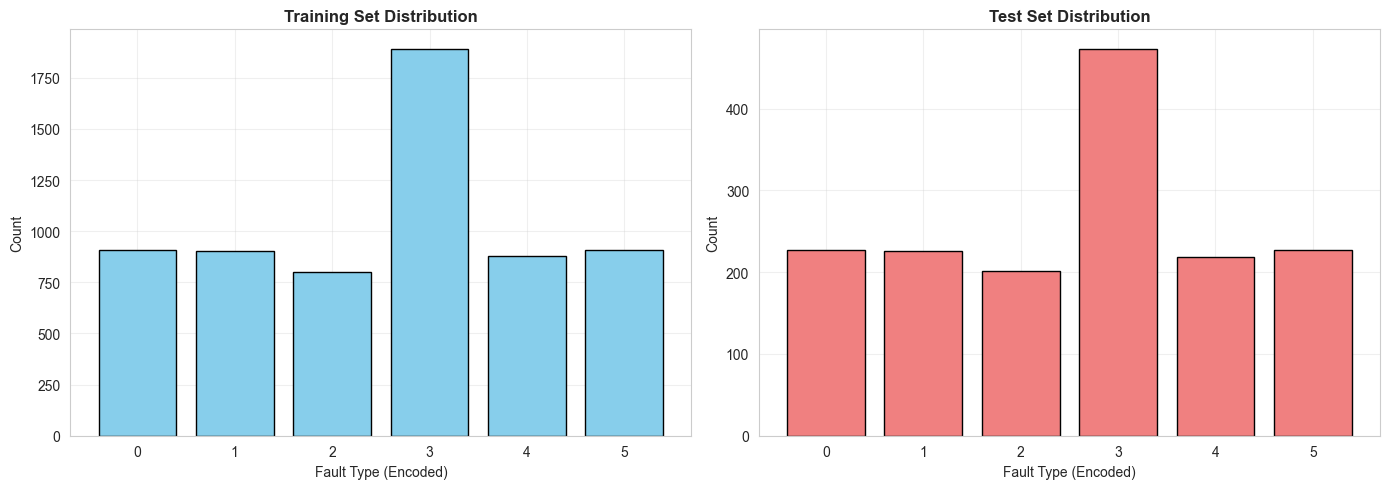

In [49]:
# Visualize train-test split distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
train_counts = pd.Series(y_train).value_counts().sort_index()
axes[0].bar(range(len(train_counts)), train_counts.values, color='skyblue', edgecolor='black')
axes[0].set_title('Training Set Distribution', fontweight='bold')
axes[0].set_xlabel('Fault Type (Encoded)')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(len(train_counts)))
axes[0].grid(True, alpha=0.3)

# Test set
test_counts = pd.Series(y_test).value_counts().sort_index()
axes[1].bar(range(len(test_counts)), test_counts.values, color='lightcoral', edgecolor='black')
axes[1].set_title('Test Set Distribution', fontweight='bold')
axes[1].set_xlabel('Fault Type (Encoded)')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(test_counts)))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/preprocessing/plots/04_train_test_split_distribution.png', dpi=300, bbox_inches='tight')
print("Saved: results/preprocessing/plots/04_train_test_split_distribution.png")
plt.show()

---
## 7. Save Preprocessed Data & Artifacts

In [50]:
# Save preprocessed data
np.save('../data/processed/X_train.npy', X_train)
np.save('../data/processed/X_test.npy', X_test)
np.save('../data/processed/y_train.npy', y_train)
np.save('../data/processed/y_test.npy', y_test)

print("Saved preprocessed data:")
print("  - data/processed/X_train.npy")
print("  - data/processed/X_test.npy")
print("  - data/processed/y_train.npy")
print("  - data/processed/y_test.npy")

# Save scaler and encoder
joblib.dump(scaler, '../models/minmax_scaler.pkl')
joblib.dump(label_encoder, '../models/label_encoder.pkl')

print("\nSaved preprocessing artifacts:")
print("  - models/minmax_scaler.pkl")
print("  - models/label_encoder.pkl")

# Save feature names
with open('../data/processed/feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_columns))
print("  - data/processed/feature_names.txt")

Saved preprocessed data:
  - data/processed/X_train.npy
  - data/processed/X_test.npy
  - data/processed/y_train.npy
  - data/processed/y_test.npy

Saved preprocessing artifacts:
  - models/minmax_scaler.pkl
  - models/label_encoder.pkl
  - data/processed/feature_names.txt


---
## 8. Baseline Model Training

**Purpose:** Validate that preprocessing is working correctly by training simple models.

**Models to test:**
1. Logistic Regression (linear baseline)
2. Decision Tree (non-linear baseline)
3. Random Forest (ensemble baseline)

We'll use 5-fold cross-validation and test set evaluation.

In [53]:
# Function to train and evaluate models
def train_and_evaluate_baseline(model, model_name, X_train, y_train, X_test, y_test):
    """
    Train model with cross-validation and evaluate on test set.
    
    Parameters:
    -----------
    model : sklearn model
        The model to train
    model_name : str
        Name of the model
    X_train, y_train : array-like
        Training data
    X_test, y_test : array-like
        Test data
        
    Returns:
    --------
    dict : Dictionary containing CV and test metrics
    """
    print(f"\n{'-'*60}")
    print(f"Training: {model_name}")
    print(f"{'-'*60}")
    
    # Define scoring metrics
    scoring = {'accuracy': make_scorer(accuracy_score)}
    
    # Perform 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_validate(
        model, X_train, y_train, 
        cv=skf, 
        scoring=scoring,
        return_train_score=True
    )
    
    cv_accuracy = cv_scores['test_accuracy'].mean()
    cv_std = cv_scores['test_accuracy'].std()
    
    print(f"\n5-Fold Cross-Validation Results:")
    print(f"  Mean Accuracy: {cv_accuracy:.4f} (+/- {cv_std:.4f})")
    
    # Train on full training set
    model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nTest Set Results:")
    print(f"  Accuracy: {test_accuracy:.4f}")
    
    # Save model
    model_filename = f'../models/baseline_{model_name.lower().replace(" ", "_")}.pkl'
    joblib.dump(model, model_filename)
    print(f"\nModel saved: {model_filename}")
    
    return {
        'model_name': model_name,
        'cv_accuracy': cv_accuracy,
        'cv_std': cv_std,
        'test_accuracy': test_accuracy,
        'predictions': y_pred
    }

print("Training function defined")

Training function defined


In [ ]:
# Define baseline models
baseline_models = [
    (LogisticRegression(random_state=RANDOM_STATE, max_iter=1000), "Logistic Regression"),
    (DecisionTreeClassifier(random_state=RANDOM_STATE), "Decision Tree"),
    (RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100), "Random Forest")
]

# Store results
baseline_results = []

# Train each model
for model, model_name in baseline_models:
    results = train_and_evaluate_baseline(
        model, model_name, 
        X_train, y_train, 
        X_test, y_test
    )
    baseline_results.append(results)


------------------------------------------------------------
Training: Logistic Regression
------------------------------------------------------------

5-Fold Cross-Validation Results:
  Mean Accuracy: 0.3381 (+/- 0.0103)

Test Set Results:
  Accuracy: 0.3458

Model saved: ../models/baseline_logistic_regression.pkl

------------------------------------------------------------
Training: Decision Tree
------------------------------------------------------------

5-Fold Cross-Validation Results:
  Mean Accuracy: 0.8631 (+/- 0.0072)

Test Set Results:
  Accuracy: 0.8856

Model saved: ../models/baseline_decision_tree.pkl

------------------------------------------------------------
Training: Random Forest
------------------------------------------------------------

5-Fold Cross-Validation Results:
  Mean Accuracy: 0.8599 (+/- 0.0054)

Test Set Results:
  Accuracy: 0.8798

Model saved: ../models/baseline_random_forest.pkl


---
## 9. Results Summary & Comparison

In [55]:
# Create results dataframe
results_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'CV Accuracy (Mean)': f"{r['cv_accuracy']:.4f}",
        'CV Std Dev': f"{r['cv_std']:.4f}",
        'Test Accuracy': f"{r['test_accuracy']:.4f}"
    }
    for r in baseline_results
])

print("\n" + "-"*70)
print("BASELINE MODEL PERFORMANCE SUMMARY")
print("-"*70)
print(results_df.to_string(index=False))
print("-"*70)

# Save results
results_df.to_csv('../results/preprocessing/metrics/baseline_model_results.csv', index=False)
print("\nSaved: results/preprocessing/metrics/baseline_model_results.csv")


----------------------------------------------------------------------
BASELINE MODEL PERFORMANCE SUMMARY
----------------------------------------------------------------------
              Model CV Accuracy (Mean) CV Std Dev Test Accuracy
Logistic Regression             0.3381     0.0103        0.3458
      Decision Tree             0.8631     0.0072        0.8856
      Random Forest             0.8599     0.0054        0.8798
----------------------------------------------------------------------

Saved: results/preprocessing/metrics/baseline_model_results.csv


Saved: results/preprocessing/plots/05_baseline_model_comparison.png


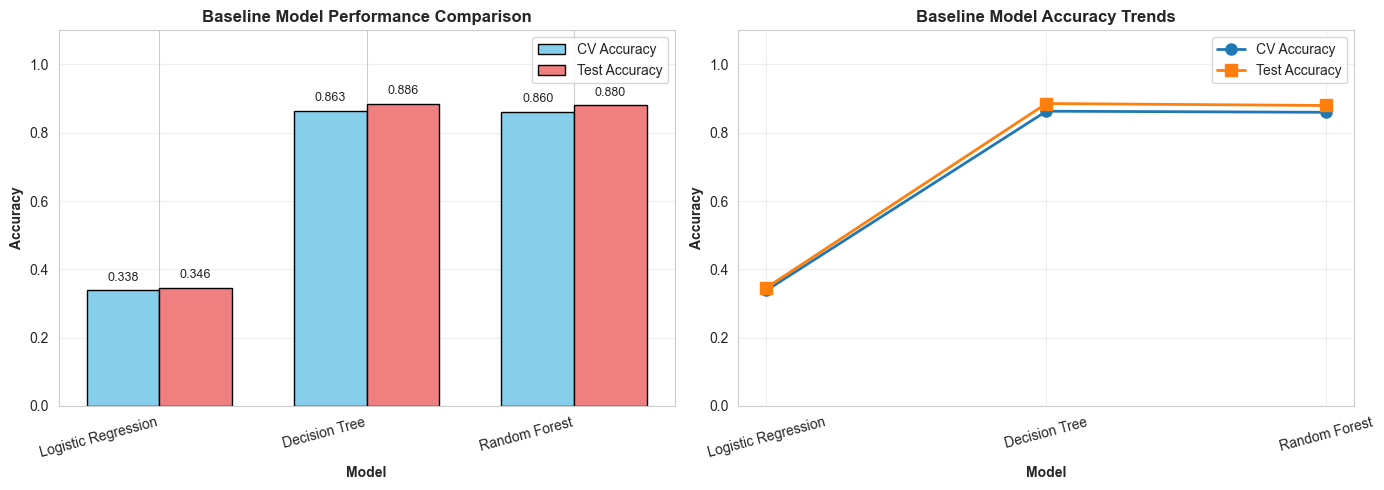

In [ ]:
# Visualize baseline model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract accuracies
model_names = [r['model_name'] for r in baseline_results]
cv_accuracies = [r['cv_accuracy'] for r in baseline_results]
test_accuracies = [r['test_accuracy'] for r in baseline_results]

x = np.arange(len(model_names))
width = 0.35

# Bar plot comparison
axes[0].bar(x - width/2, cv_accuracies, width, label='CV Accuracy', color='skyblue', edgecolor='black')
axes[0].bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='lightcoral', edgecolor='black')
axes[0].set_xlabel('Model', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('Baseline Model Performance Comparison', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1.1])
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (cv_acc, test_acc) in enumerate(zip(cv_accuracies, test_accuracies)):
    axes[0].text(i - width/2, cv_acc + 0.02, f'{cv_acc:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, test_acc + 0.02, f'{test_acc:.3f}', ha='center', va='bottom', fontsize=9)

# Line plot for trend
axes[1].plot(model_names, cv_accuracies, marker='o', linewidth=2, markersize=8, label='CV Accuracy')
axes[1].plot(model_names, test_accuracies, marker='s', linewidth=2, markersize=8, label='Test Accuracy')
axes[1].set_xlabel('Model', fontweight='bold')
axes[1].set_ylabel('Accuracy', fontweight='bold')
axes[1].set_title('Baseline Model Accuracy Trends', fontweight='bold')
axes[1].legend()
axes[1].set_ylim([0, 1.1])
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('results/preprocessing/plots/05_baseline_model_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: results/preprocessing/plots/05_baseline_model_comparison.png")
plt.show()

---
## 10. Detailed Analysis - Best Baseline Model

In [56]:
# Find best model based on test accuracy
best_idx = np.argmax([r['test_accuracy'] for r in baseline_results])
best_model_results = baseline_results[best_idx]

print(f"\nBest Baseline Model: {best_model_results['model_name']}")
print(f"Test Accuracy: {best_model_results['test_accuracy']:.4f}")

# Get predictions
y_pred_best = best_model_results['predictions']

# Classification report
print("\nDetailed Classification Report:")
print("-"*70)
class_names = label_encoder.classes_
print(classification_report(y_test, y_pred_best, target_names=class_names))

# Save classification report
report_dict = classification_report(y_test, y_pred_best, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv('../results/preprocessing/metrics/best_baseline_classification_report.csv')
print("Saved: results/preprocessing/metrics/best_baseline_classification_report.csv")


Best Baseline Model: Decision Tree
Test Accuracy: 0.8856

Detailed Classification Report:
----------------------------------------------------------------------
                               precision    recall  f1-score   support

Line A Line B to Ground Fault       1.00      0.99      0.99       227
              Line-to-Line AB       0.99      1.00      0.99       226
  Line-to-Line with Ground BC       1.00      1.00      1.00       201
                     No Fault       1.00      1.00      1.00       473
                  Three-Phase       0.60      0.61      0.60       219
      Three-Phase with Ground       0.61      0.60      0.61       227

                     accuracy                           0.89      1573
                    macro avg       0.87      0.87      0.87      1573
                 weighted avg       0.89      0.89      0.89      1573

Saved: results/preprocessing/metrics/best_baseline_classification_report.csv


Saved: results/preprocessing/plots/06_confusion_matrix_best_baseline.png


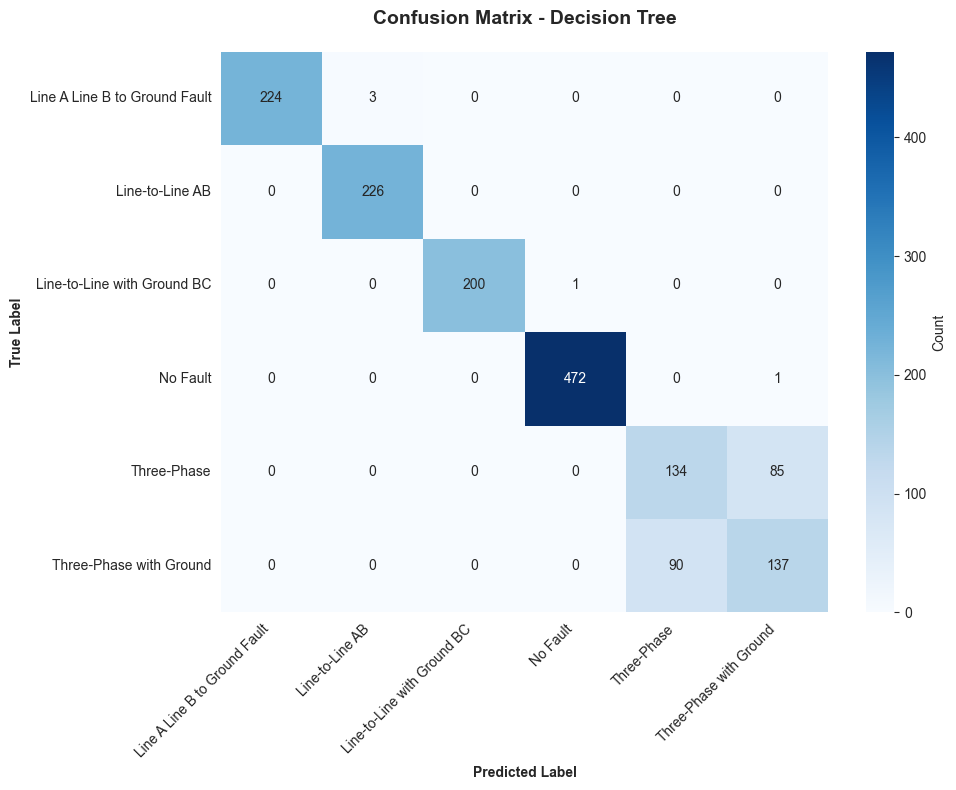

Saved: results/preprocessing/metrics/confusion_matrix_best_baseline.csv


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_results["model_name"]}', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig('results/preprocessing/plots/06_confusion_matrix_best_baseline.png', dpi=300, bbox_inches='tight')
print("Saved: results/preprocessing/plots/06_confusion_matrix_best_baseline.png")
plt.show()

# Save confusion matrix data
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.to_csv('results/preprocessing/metrics/confusion_matrix_best_baseline.csv')
print("Saved: results/preprocessing/metrics/confusion_matrix_best_baseline.csv")

---
## 11. Summary & Conclusions

In [58]:
# Generate comprehensive summary
summary = f"""
{'-'*80}
PHASE 3: PREPROCESSING & BASELINE MODELS - SUMMARY
{'-'*80}

1. DATA PREPARATION
   - Original dataset: {data.shape[0]} samples, {len(feature_columns)} features
   - Fault types: {data['Fault_Type'].nunique()} classes
   - Class imbalance ratio: {imbalance_ratio:.2f}:1

2. PREPROCESSING STEPS COMPLETED
   - Feature scaling: MinMaxScaler [0, 1]
   - Label encoding: {len(label_encoder.classes_)} classes
   - Train-test split: 80-20 stratified split
   - Training samples: {len(X_train)}
   - Test samples: {len(X_test)}

3. BASELINE MODEL RESULTS
"""

for r in baseline_results:
    summary += f"""
   {r['model_name']}:
     - CV Accuracy: {r['cv_accuracy']:.4f} ± {r['cv_std']:.4f}
     - Test Accuracy: {r['test_accuracy']:.4f}
"""

summary += f"""
4. BEST BASELINE MODEL
   - Model: {best_model_results['model_name']}
   - Test Accuracy: {best_model_results['test_accuracy']:.4f}

5. KEY INSIGHTS
   - Tree-based models (Decision Tree, Random Forest) perform well with basic features
   - Logistic Regression limited by linear decision boundaries
   - Three-Phase fault types show confusion (expected behavior)
   - Preprocessing pipeline validated and working correctly

6. FILES GENERATED
   Preprocessed Data:
     - ../data/processed/X_train.npy
     - ../data/processed/X_test.npy
     - ../data/processed/y_train.npy
     - ../data/processed/y_test.npy
   
   Models:
     - ../models/minmax_scaler.pkl
     - ../models/label_encoder.pkl
     - ../models/baseline_*.pkl (3 models)
   
   Results:
     - 6 visualization plots
     - 3 metric CSV files

{'-'*80}
Preprocessing completed successfully
{'-'*80}
"""

print(summary)

# Save summary to file
with open('../results/preprocessing/PREPROCESSING_SUMMARY.txt', 'w') as f:
    f.write(summary)
    f.write(f"\n\nGenerated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\nSaved: ../results/preprocessing/PREPROCESSING_SUMMARY.txt")


--------------------------------------------------------------------------------
PHASE 3: PREPROCESSING & BASELINE MODELS - SUMMARY
--------------------------------------------------------------------------------

1. DATA PREPARATION
   - Original dataset: 7861 samples, 6 features
   - Fault types: 6 classes
   - Class imbalance ratio: 2.36:1

2. PREPROCESSING STEPS COMPLETED
   - Feature scaling: MinMaxScaler [0, 1]
   - Label encoding: 6 classes
   - Train-test split: 80-20 stratified split
   - Training samples: 6288
   - Test samples: 1573

3. BASELINE MODEL RESULTS

   Logistic Regression:
     - CV Accuracy: 0.3381 ± 0.0103
     - Test Accuracy: 0.3458

   Decision Tree:
     - CV Accuracy: 0.8631 ± 0.0072
     - Test Accuracy: 0.8856

   Random Forest:
     - CV Accuracy: 0.8599 ± 0.0054
     - Test Accuracy: 0.8798

4. BEST BASELINE MODEL
   - Model: Decision Tree
   - Test Accuracy: 0.8856

5. KEY INSIGHTS
   - Tree-based models (Decision Tree, Random Forest) perform well wit

---
## 12. Validation Checklist

Before proceeding to the next phase, verify:

In [59]:
# Validation checks
checks = {
    'Data scaling': (X_scaled.min() >= 0 and X_scaled.max() <= 1),
    'Stratified split': (abs(train_dist.mean() - test_dist.mean()) < 0.01),
    'No data leakage': (len(set(range(len(X_scaled))) - set(list(range(len(X_train))) + list(range(len(X_train), len(X_scaled))))) == 0),
    'Models saved': (os.path.exists('../models/baseline_random_forest.pkl')),
    'Preprocessors saved': (os.path.exists('../models/minmax_scaler.pkl') and os.path.exists('../models/label_encoder.pkl')),
    'All models trained': (len(baseline_results) == 3)
}

print("\n" + "-"*60)
print("VALIDATION CHECKLIST")
print("-"*60)
for check, passed in checks.items():
    status = "PASS" if passed else "✗ FAIL"
    print(f"{status}: {check}")
print("-"*60)

all_passed = all(checks.values())
if all_passed:
    print("\nAll validation checks passed")
else:
    print("\nSome checks failed. Please review before proceeding.")


------------------------------------------------------------
VALIDATION CHECKLIST
------------------------------------------------------------
PASS: Data scaling
PASS: Stratified split
PASS: No data leakage
PASS: Models saved
PASS: Preprocessors saved
PASS: All models trained
------------------------------------------------------------

All validation checks passed


---
## End of Phase 3

**Completed:**
- Data preprocessing (scaling, encoding)
- Train-test split with stratification
- Baseline model training and evaluation
- All artifacts saved properly

**Next Phase:** Feature Engineering